# Ausbau des 5G-Netzes in der Schweiz
Das Bundesamt für Kommunikation der Schweiz publiziert [eine Karte](https://map.geo.admin.ch/?topic=funksender&lang=de&bgLayer=ch.swisstopo.pixelkarte-farbe&layers=ch.bakom.mobil-antennenstandorte-5g,ch.bakom.radio-fernsehsender,ch.bakom.mobil-antennenstandorte-gsm,ch.bakom.mobil-antennenstandorte-umts,ch.bakom.mobil-antennenstandorte-lte&catalogNodes=403,408&layers_visibility=true,false,true,true,true), auf der die Standorte der aktuell erfassten Sendeanlagen eingezeichnet sind. Um den Ausbau des 5G-Netzes zu dokumentieren, haben wir im letzten Halbjahr die zugrunde liegenden Informationen einmal täglich von einem Computerskript auslesen lassen. Diese Daten sollen in diesem Notebook ausgewertet werden. Es bildet die Grundlage für einen Artikel in den Tamedia-Medien. 

Die Daten enthalten alle Mobilfunkstandorte der fünften Generation. Die Werte können leicht von den Angaben abweichen, die das Bundesamt für Kommunikation jeweils kommuniziert. Dies aus zwei Gründen: Antennen, die sich weniger als 20 Meter voneinander installiert sind, werden für die Karte zu einer Anlage zusammengefasst. Zudem sind in den Daten einzelne Kleinstantennen verzeichnet, die in den kommunizierten Zahlen nicht mitgezählt werden. Weitere Informationen zum Datensatz sind auf der [Bakom-Website](https://www.bakom.admin.ch/bakom/de/home/frequenzen-antennen/standorte-von-sendeanlagen/erlaeuterungen-zur-uebersichtskarte.html) zu finden. 

Für Rückfragen zu dieser Datenauswertung: [Mathias Born](mailto:mathias.born@tamedia.ch) (Datendesk) und [Jon Mettler](jon.mettler@tamedia.ch) (Wirtschaftsressort).

In [2]:
# Die nötigen Bibliotheken werden importiert. 
import pandas as pd
import json
import ast
from time import sleep
from os import listdir
import re

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import geopandas as gpd
import folium

In [2]:
# Einlesen der im Laufe der Zeit auf dem eigenen Server gespeicherten Daten. 
!rsync root@do2:/root/5g/archiv/*.csv /home/this/Dokumente/bz/datendesk/morgenteam/5G/daten/

In [3]:
# Die heruntergeladenen Daten zu den Standorten der 5G-Antennen werden eingelesen. 
df = pd.DataFrame()

fl = listdir('daten')
fl = [x for x in fl if '5g_' in x]

for i in fl:
    df_temp = pd.read_csv('daten/' + i, index_col='Unnamed: 0')
    df_temp['file'] = i
    df_temp['datum'] = re.search('\d{4}-\d{2}-\d{2}', i).group(0)
    df = df.append(df_temp)

In [4]:
# Ein Blick auf die ersten paar Zeilen der Tabelle. 
df.head()

geometry  \
0  {'type': 'Point', 'coordinates': [2538396, 115...   
1  {'type': 'Point', 'coordinates': [2742666, 124...   
2  {'type': 'Point', 'coordinates': [2675332, 125...   
3  {'type': 'Point', 'coordinates': [2689383, 125...   
4  {'type': 'Point', 'coordinates': [2605345, 120...   

                                          properties     type  lat_2056  \
0  {'lang': 'de', 'description': '<table>\n<tr><t...  Feature   2538396   
1  {'lang': 'de', 'description': '<table>\n<tr><t...  Feature   2742666   
2  {'lang': 'de', 'description': '<table>\n<tr><t...  Feature   2675332   
3  {'lang': 'de', 'description': '<table>\n<tr><t...  Feature   2689383   
4  {'lang': 'de', 'description': '<table>\n<tr><t...  Feature   2605345   

   lon_2056   power               file       datum  
0   1152692   Klein  5g_2020-01-01.csv  2020-01-01  
1   1248124  Mittel  5g_2020-01-01.csv  2020-01-01  
2   1256337   Klein  5g_2020-01-01.csv  2020-01-01  
3   1255207  Mittel  5g_2020-01-01.csv  2020-01-01  
4   1203884  Mittel  5g_2020-01-01.csv  2020-01-01

In [5]:
# Wie viele Einträge enthält die Tabelle? 
len(df)

157726

In [7]:
# Die Daten enthalten Koordinaten im Schweizer Bezugssystem. Orts- und Kantonsangaben fehlen. 
# Im folgenden werden diese Angaben ergänzt.

# Ein Datensatz mit den Umrissen aller Schweizer Gemeinden wird geladen. Die Daten stammen von Swisstopo. 
gdf_gemeinden = gpd.read_file('../../grundlagendaten/karten/CHE_adm3.shp')
gdf_gemeinden['geometry'] = gdf_gemeinden['geometry'].to_crs(epsg=2056)

In [8]:
# Ein Verzeichnis aller Standorte wird erstellt. 
df_geo = df[['lat_2056', 'lon_2056']].drop_duplicates()

In [9]:
# Wie viele Einträge sind im Geodatensatz vorhanden? 
len(df_geo)

2376

In [10]:
# Die früher abgespeicherten Daten werden ergänzt. 
df_temp = pd.read_csv('daten/antennen.csv', index_col='Unnamed: 0')[['lat_2056', 'lon_2056', 'lat', 'lon']].drop_duplicates()
df_geo = pd.merge(df_geo, df_temp, left_on=['lat_2056', 'lon_2056'], right_on=['lat_2056', 'lon_2056'], how='left')

In [11]:
# Wie viele Einträge sind im Geodatensatz vorhanden? 
len(df_geo)

2376

In [11]:
# Die Standorte der neuen Antennen werden vom Schweizer Koordinatensystem ins einfacher verarbeitbare WGS84 
# umgewandelt. To do: Allenfalls ist dieser zeitaufwändige Schritt überflüssig. Bislang schaffte ich es aber
# nicht, die Schweizer Projektion in Geopandas einzulesen. 

def to_latlon(latlon_2056):
    r = get('http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting=' + str(latlon_2056[0]) + '&northing=' + str(latlon_2056[1]) + '&format=json')
    latlon = ast.literal_eval(r.content[:-1].decode('utf-8'))
    lat = latlon['northing']
    lon = latlon['easting']
    sleep(.5)
    return [lat,lon]

for i, r in df_geo[df_geo['lat'].isnull()].iterrows():
    print(i, end='\r')
    c = to_latlon(r.tolist())
    df_geo.at[i, 'lat'] = c[0]
    df_geo.at[i, 'lon'] = c[1]
    
df_geo = df_geo.reset_index()
del df_geo['index']

In [12]:
# Ein Geodataframe wird erstellt. 
gdf_geo = gpd.GeoDataFrame(df_geo, geometry=gpd.points_from_xy(df_geo['lon'].astype('float'), df_geo['lat'].astype('float')))
gdf_geo.crs = {'init' :'epsg:4326'}
gdf_geo['geometry'] = gdf_geo['geometry'].to_crs(epsg=2056)

# Liegt ein Punkt innerhalb einer Gemeinde-Geometrie, werden die Gemeindeinfos hinzugefügt. 
gdf_geo = gpd.sjoin(gdf_geo, gdf_gemeinden, how='left', op="within")

In [13]:
# Die Geodaten werden dem Antennendatensatz hinzugefügt. 
gdf_geo = gdf_geo[['lat_2056', 'lon_2056', 'lat', 'lon', 'NAME_1', 'NAME_2', 'NAME_3']]
df = pd.merge(df, gdf_geo, left_on=['lat_2056', 'lon_2056'], right_on=['lat_2056', 'lon_2056'], how='left')

In [14]:
# Die IDs der Antennen werden ausgelesen. 
df['id'] = df['properties'].apply(lambda x: ast.literal_eval(x)['id'])

# Zum einfacheren Sortieren wird das Datum in einen Datetime-Datentyp verwandelt. 
df['datetime'] = pd.to_datetime(df['datum'])
df = df.sort_values(by=['datetime', 'id'])

In [15]:
# Der Datensatz wird abgespeichert. 
df.to_csv('daten/antennen.csv')

In [3]:
# Die Daten werden neu geladen, falls die oben stehenden Schritte übersprungen werden sollen. 
df = pd.read_csv('daten/antennen.csv', index_col='Unnamed: 0')

In [17]:
# Wie viele Einträge sind im Datensatz enthalten? 
len(df)

157726

## Auswertungen

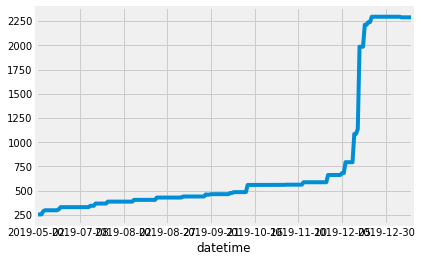

In [18]:
# Wie entwickelt sich die Anzahl 5G-Antennen im Laufe der Zeit?
df.groupby(by='datetime')['file'].count().plot()

In [19]:
# Exportieren der Daten. 
df.groupby(by='datetime')[['file']].count().to_excel('output/5g_historisch.xlsx')

In [20]:
# Exportieren der Daten für den Datawrapper. 
print(df.groupby(by='datum')['file'].count().to_csv())

2019-05-02,255
2019-05-04,255
2019-05-05,255
2019-05-07,255
2019-06-06,286
2019-06-18,298
2019-06-19,298
2019-06-20,298
2019-06-21,298
2019-06-22,298
2019-06-23,298
2019-06-24,298
2019-06-25,298
2019-06-26,308
2019-06-27,330
2019-06-28,330
2019-06-29,330
2019-06-30,330
2019-07-01,330
2019-07-02,330
2019-07-03,330
2019-07-04,330
2019-07-05,330
2019-07-06,330
2019-07-07,330
2019-07-08,330
2019-07-09,330
2019-07-10,330
2019-07-11,330
2019-07-12,330
2019-07-13,330
2019-07-14,344
2019-07-15,344
2019-07-16,344
2019-07-17,367
2019-07-18,367
2019-07-19,367
2019-07-20,367
2019-07-21,367
2019-07-22,367
2019-07-23,367
2019-07-24,387
2019-07-25,387
2019-07-26,387
2019-07-27,387
2019-07-28,387
2019-07-29,387
2019-07-30,387
2019-07-31,387
2019-08-01,387
2019-08-02,387
2019-08-03,387
2019-08-04,387
2019-08-05,387
2019-08-06,387
2019-08-07,387
2019-08-08,405
2019-08-09,405
2019-08-10,405
2019-08-11,405
2019-08-12,405
2019-08-13,405
2019-08-14,405
2019-08-15,405
2019-08-16,405
2019-08-17,405
2019-08-18

/home/this/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [21]:
# Wie viele 5G-Antennen sind in Betrieb? 
df_aktuell = df[df['datum'] == df['datum'].max()]
len(df_aktuell)

2289

In [22]:
# Wie viele 5G-Antennen waren am 1. November in Betrieb? 
len(df[df['datum'] == '2019-11-01'])

560

In [23]:
# Wie viele 5G-Antennen waren am 1. Dezember in Betrieb? 
len(df[df['datum'] == '2019-12-01'])

662

In [24]:
# Wie viele 5G-Antennen waren am 1. Januar 2020 in Betrieb? 
len(df[df['datum'] == '2020-01-01'])

2295

In [25]:
# Wie viele Antennen kamen demnach zwischen anfangs Dezember und anfangs Januar hinzu? 
len(df[df['datum'] == '2020-01-01']) - len(df[df['datum'] == '2019-12-01'])

1633

In [26]:
# Wie stark sind die aktuell laufenden Antennen? 
df_power = pd.DataFrame(df_aktuell['power'].value_counts())
df_power['prozent'] = 100 * df_power / df_power.sum()
df_power

power    prozent
Mittel       1246  54.434251
Klein         885  38.663172
Gross         149   6.509393
Sehr Klein      9   0.393185

/home/this/.local/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


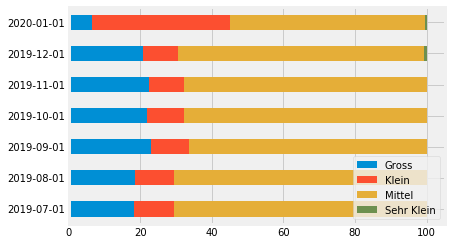

In [27]:
# Wie verändert sich der "Power-Mix" (das Verhältnis von kleinen, mittleren und grossen Anlagen) im Laufe der Zeit?
df_temp_2 = pd.DataFrame()
for m in ['2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01']:
    df_temp = df[df['datum'] == m]
    df_temp = pd.DataFrame(df_temp['power'].value_counts())
    df_temp['prozent'] = 100 * df_temp / df_temp.sum()
    df_temp = df_temp[['prozent']]
    df_temp.columns = [m]
    df_temp = df_temp.transpose()
    df_temp_2 = df_temp_2.append(df_temp)
    
df_temp_2.plot(kind='barh', stacked=True)

In [28]:
# Die Rohdaten aus der vorangehenden Grafik. 
df_temp_2

Gross      Klein     Mittel  Sehr Klein
2019-07-01  18.181818  11.212121  70.606061         NaN
2019-08-01  18.604651  10.852713  70.542636         NaN
2019-09-01  23.076923  10.489510  66.433566         NaN
2019-10-01  21.767241  10.344828  67.887931         NaN
2019-11-01  22.500000   9.642857  67.857143         NaN
2019-12-01  20.845921   9.667674  68.882175    0.604230
2020-01-01   6.448802  38.649237  54.553377    0.348584

In [29]:
# Wie viele Antennenstandorte gibt es aktuell pro Kanton? 
df_aktuell['NAME_1'].value_counts()

Bern                      419
Zürich                    372
Aargau                    217
Vaud                      167
Graubünden                117
Genève                    109
Solothurn                 100
Ticino                     98
Sankt Gallen               97
Valais                     86
Fribourg                   83
Lucerne                    81
Thurgau                    71
Basel-Landschaft           67
Schwyz                     50
Zug                        24
Basel-Stadt                23
Schaffhausen               22
Neuchâtel                  18
Nidwalden                  16
Jura                       13
Uri                        10
Glarus                      8
Obwalden                    8
Appenzell Ausserrhoden      6
Appenzell Innerrhoden       3
Name: NAME_1, dtype: int64

In [30]:
# Export für den Datawrapper: Wie viele Antennenstandorte gibt es aktuell pro Kanton? 
print(df_aktuell['NAME_1'].value_counts().to_csv())

Bern,419
Zürich,372
Aargau,217
Vaud,167
Graubünden,117
Genève,109
Solothurn,100
Ticino,98
Sankt Gallen,97
Valais,86
Fribourg,83
Lucerne,81
Thurgau,71
Basel-Landschaft,67
Schwyz,50
Zug,24
Basel-Stadt,23
Schaffhausen,22
Neuchâtel,18
Nidwalden,16
Jura,13
Uri,10
Glarus,8
Obwalden,8
Appenzell Ausserrhoden,6
Appenzell Innerrhoden,3



/home/this/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [31]:
# Wie viele Antennenstandorte gibt es Anfang Dezember und Anfang Januar? Wie gross ist der Zuwachs?
df_temp = df[df['datum'] == '2020-01-01'].groupby(by='NAME_1')[['id']].count()
df_temp.columns = ['2020-01-01']
df_temp = pd.concat([df_temp, df[df['datum'] == '2019-12-01'].groupby(by='NAME_1')[['id']].count()], axis=1)
df_temp.columns = ['2020-01-01', '2019-12-01']
df_temp = df_temp.fillna(0)
df_temp['zuwachs'] = df_temp['2020-01-01'] - df_temp['2019-12-01']
df_temp = df_temp.sort_values(by='2020-01-01', ascending=False)[['2019-12-01', 'zuwachs']]
df_temp

/home/this/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


2019-12-01  zuwachs
Bern                         144.0    276.0
Zürich                       141.0    231.0
Aargau                       113.0    107.0
Vaud                          20.0    147.0
Graubünden                    42.0     75.0
Genève                        29.0     82.0
Solothurn                     24.0     78.0
Ticino                        12.0     86.0
Sankt Gallen                  18.0     79.0
Valais                        10.0     76.0
Fribourg                      15.0     66.0
Lucerne                        1.0     80.0
Thurgau                       29.0     42.0
Basel-Landschaft              13.0     54.0
Schwyz                        13.0     37.0
Zug                            0.0     24.0
Basel-Stadt                    4.0     19.0
Schaffhausen                   9.0     13.0
Neuchâtel                      5.0     13.0
Nidwalden                      5.0     11.0
Jura                           8.0      5.0
Uri                            1.0      9.0
Glarus                         2.0      6.0
Obwalden                       2.0      6.0
Appenzell Ausserrhoden         1.0      5.0
Appenzell Innerrhoden          1.0      2.0

In [32]:
# Export der oben generierten Tabelle für den Datawrapper. 
print(df_temp.to_csv())

,2019-12-01,zuwachs
Bern,144.0,276.0
Zürich,141.0,231.0
Aargau,113.0,107.0
Vaud,20.0,147.0
Graubünden,42.0,75.0
Genève,29.0,82.0
Solothurn,24.0,78.0
Ticino,12.0,86.0
Sankt Gallen,18.0,79.0
Valais,10.0,76.0
Fribourg,15.0,66.0
Lucerne,1.0,80.0
Thurgau,29.0,42.0
Basel-Landschaft,13.0,54.0
Schwyz,13.0,37.0
Zug,0.0,24.0
Basel-Stadt,4.0,19.0
Schaffhausen,9.0,13.0
Neuchâtel,5.0,13.0
Nidwalden,5.0,11.0
Jura,8.0,5.0
Uri,1.0,9.0
Glarus,2.0,6.0
Obwalden,2.0,6.0
Appenzell Ausserrhoden,1.0,5.0
Appenzell Innerrhoden,1.0,2.0



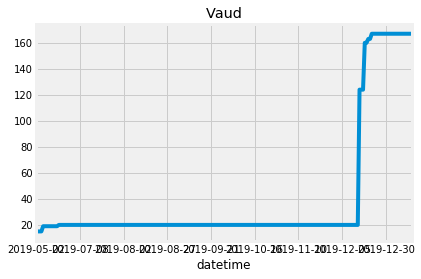

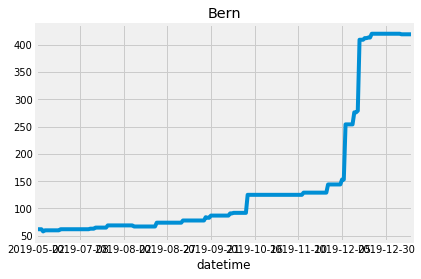

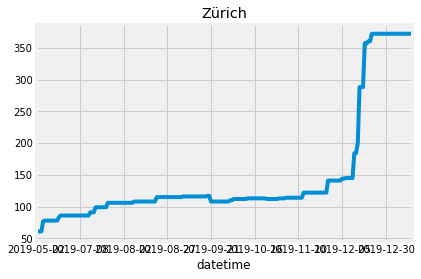

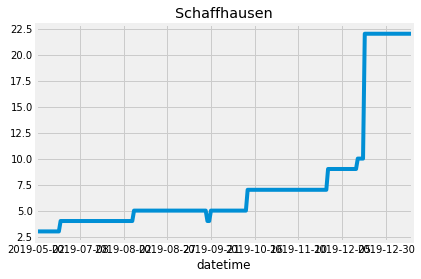

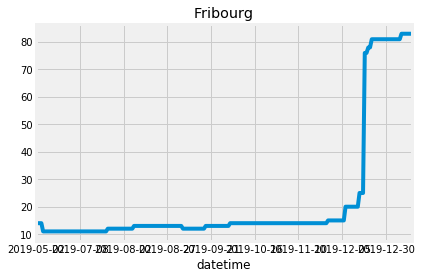

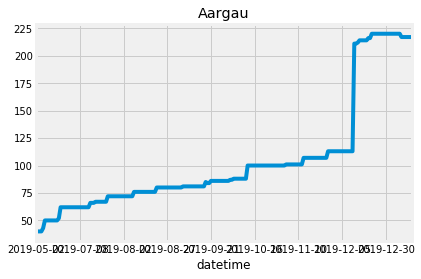

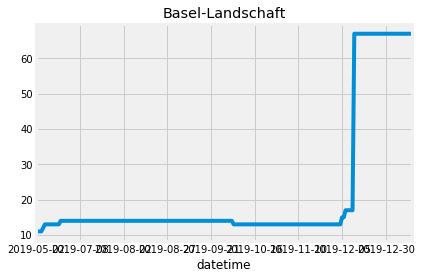

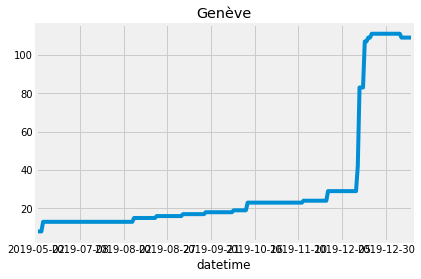

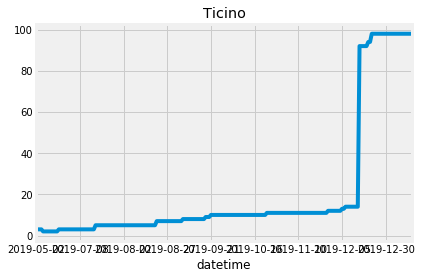

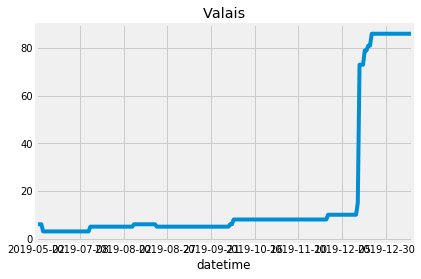

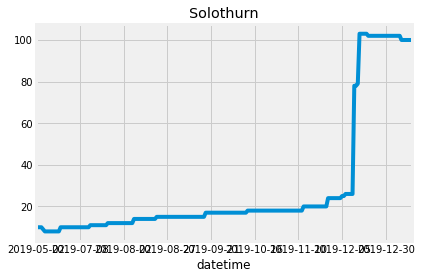

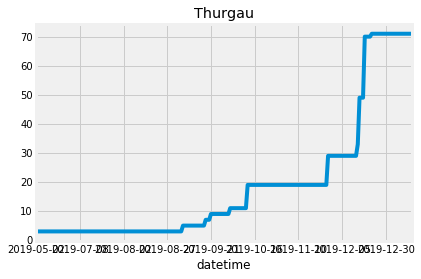

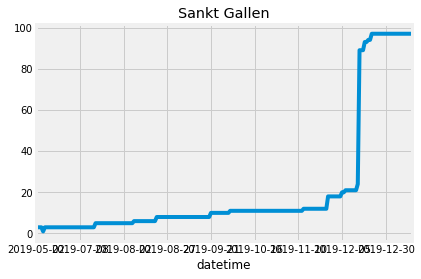

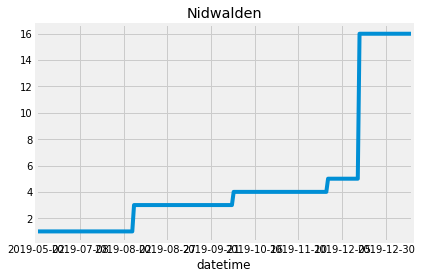

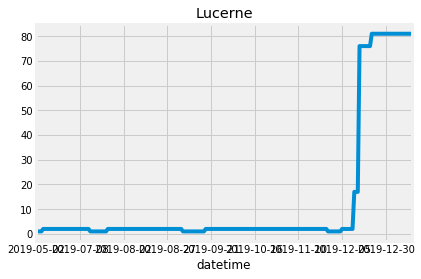

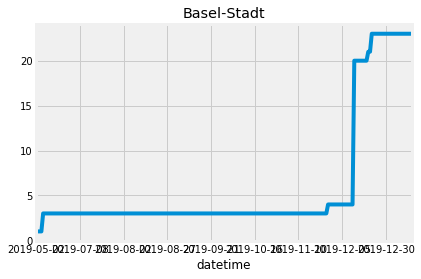

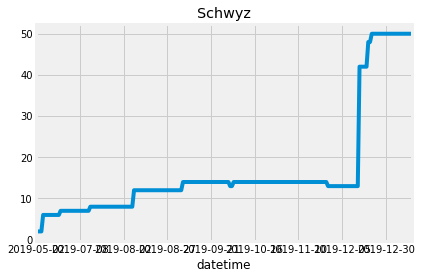

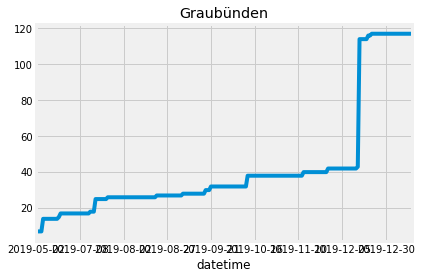

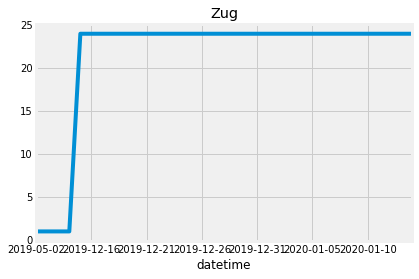

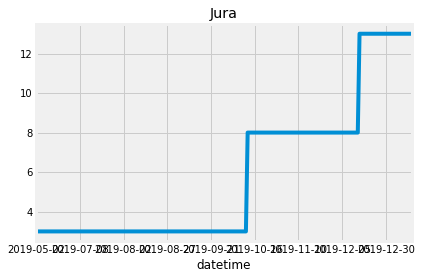

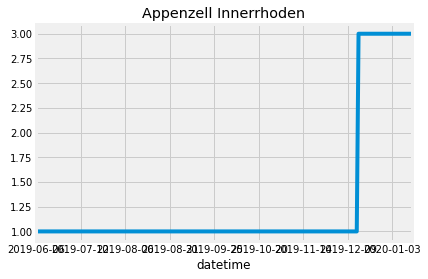

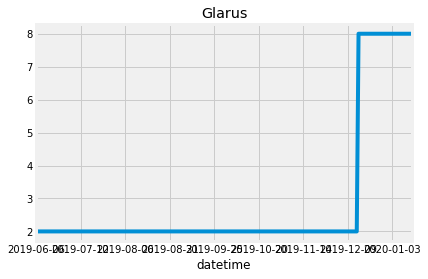

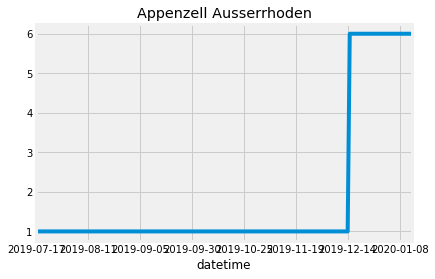

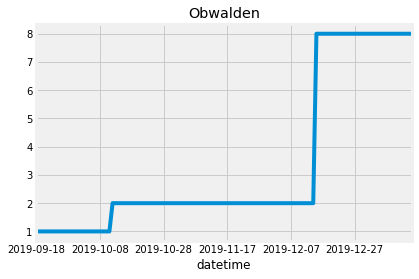

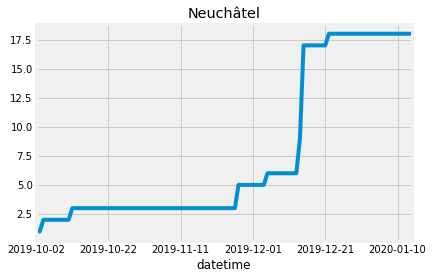

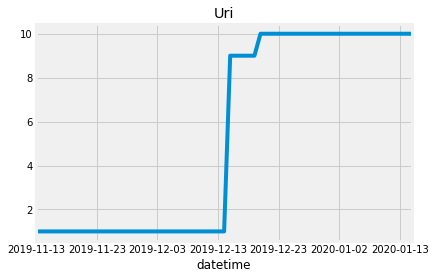

In [33]:
# Wo wurde wann gebaut? 
for k in df.dropna(subset=['NAME_1'])['NAME_1'].unique():
    fig, ax = plt.subplots()
    df[df['NAME_1'] == k].groupby(by='datetime')['NAME_1'].count().plot(title=k, ax=ax)
    plt.show()
    print()

In [4]:
# Wie viele Antennen kommen pro Monat hinzu?
df_temp = df.groupby(by='datetime')[['id']].count()
df_temp.index = pd.to_datetime(df_temp.index)
df_temp = df_temp.resample("M", how='first')  # the same
df_temp['diff'] = df_temp['id'] - df_temp['id'].shift()
df_temp

/home/this/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  after removing the cwd from sys.path.


id    diff
datetime                
2019-05-31   255     NaN
2019-06-30   286    31.0
2019-07-31   330    44.0
2019-08-31   387    57.0
2019-09-30   429    42.0
2019-10-31   464    35.0
2019-11-30   560    96.0
2019-12-31   662   102.0
2020-01-31  2295  1633.0

In [5]:
# Offenbar stehen nicht alle Antennen auf Schweizer Boden. Um wie viele Standorte handelt es sich?
# (Gezählt werden die identischen Koordinaten der Stationen.)
len(df[df['NAME_3'].isnull()].drop_duplicates(subset=['lon_2056', 'lat_2056'], keep='first'))

4

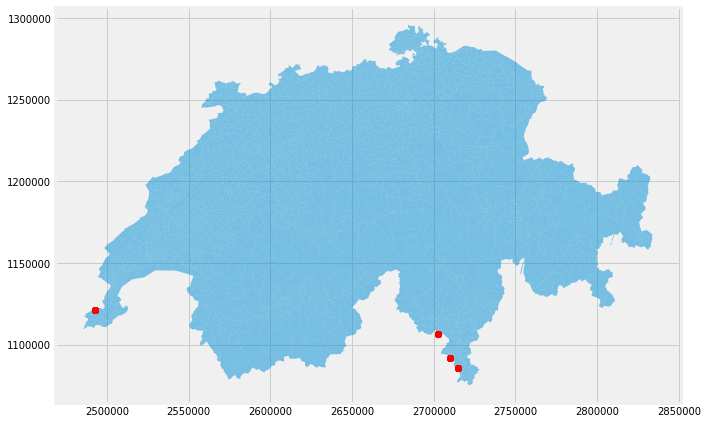

In [12]:
# Wo stehen die betreffenden Antennen? 
gdf_test = df[df['NAME_1'].isnull()].drop_duplicates(subset=['id'], keep='first')
gdf_test = gpd.GeoDataFrame(gdf_test, geometry=gpd.points_from_xy(gdf_test['lon'].astype('float'), gdf_test['lat'].astype('float')))
gdf_test.crs = {'init' :'epsg:4326'}
gdf_test['geometry'] = gdf_test['geometry'].to_crs(epsg=2056)

fig, ax = plt.subplots(figsize=[10,10])
gdf_gemeinden.plot(ax = ax, alpha=0.5)
gdf_test.plot(ax = ax, color='red')

In [13]:
# Dasselbe auf der interaktiven Karte. 
m = folium.Map(location=[46.9141,7.4972], zoom_start=8, tiles='Stamen Toner')

for index, row in gdf_test.iterrows():
    popup = ''#Anzahl Antennen:' + str(len(df[(df['lat_2056'] == r['lat_2056']) & (df['lon_2056'] == r['lon_2056'])]['id'].unique()))#5G-Antenne im Kanton ' + row['NAME_1'] + '<br/>' + 'Sendeleistung: ' + row['power']
    if row['power'] == 'Klein':
        c = 'green'
    if row['power'] == 'Mittel':
        c = 'orange'
    if row['power'] == 'Gross':
        c = 'red'
    folium.Marker([row['lat'], row['lon']], popup=popup, icon=folium.Icon(color=c),).add_to(m)
m.save('output/karte_üsserschwiz.html')
m

In [25]:
# Dass diese Tabelle nicht einem Schweizer Kanton zugeordnet werden konnten, könnte mit dem vereinfachten
# Shapefile zusammenhängen. Deshalb werden die vier Standorte manuell geprüft. Dabei zeigt sich: Alle liegen
# ganz knapp auf Schweizer Territorium. 

df_temp = gdf_test.drop_duplicates(subset=['lat_2056', 'lon_2056'])[['lat_2056', 'lon_2056', 'lat', 'lon', 'power']]

for i, r in df_temp.iterrows():
    df_temp.at[i, 'karte'] = 'https://www.openstreetmap.org/?mlat=' + str(r['lat']) + '&mlon=' + str(r['lon']) + '#map=19/' + str(r['lat']) + '/' + str(r['lon'])

for i in df_temp['karte'].tolist():
    print(i)

https://www.openstreetmap.org/?mlat=46.232892805549966&mlon=6.047217768644093#map=19/46.232892805549966/6.047217768644093
https://www.openstreetmap.org/?mlat=45.969524619189755&mlon=8.856428391071695#map=19/45.969524619189755/8.856428391071695
https://www.openstreetmap.org/?mlat=45.913484782852564&mlon=8.917039135069409#map=19/45.913484782852564/8.917039135069409
https://www.openstreetmap.org/?mlat=46.101696084380166&mlon=8.762680068959588#map=19/46.101696084380166/8.762680068959588


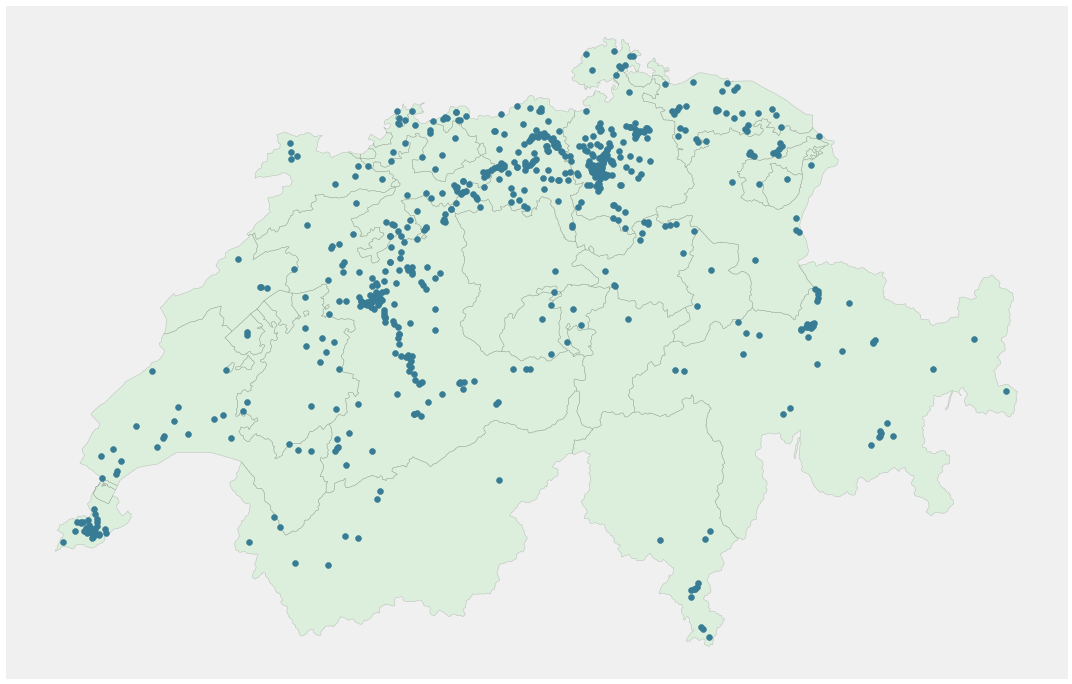

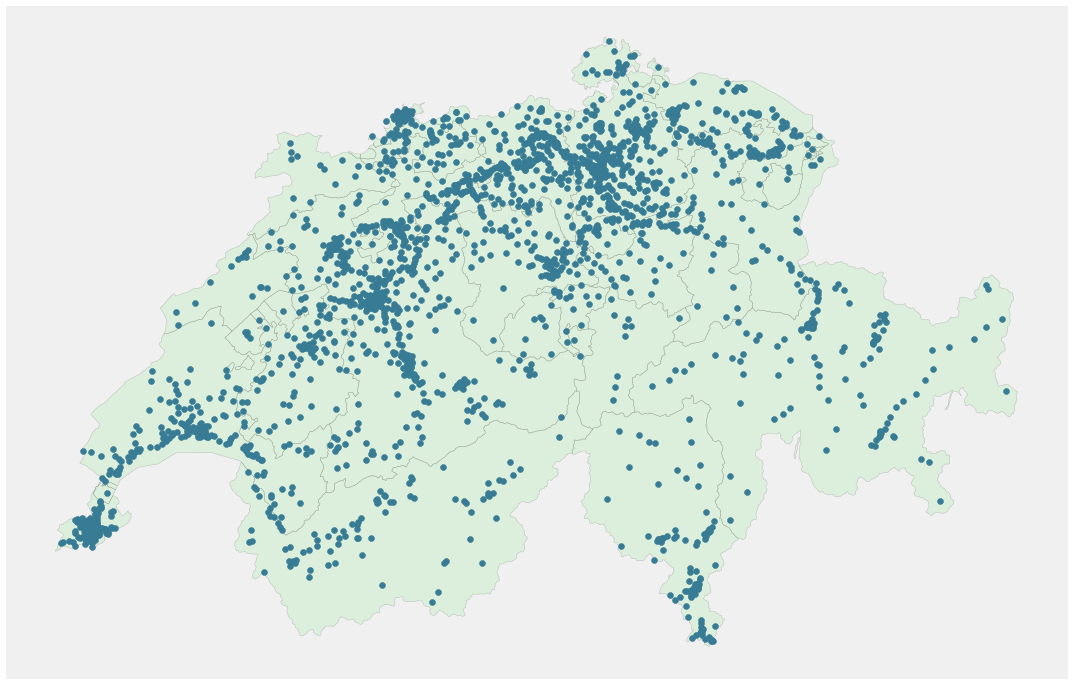

In [38]:
# Eine Karte soll generiert werden, auf der sich der Ausbaustand Anfang Dezember und Anfang Januar
# vergleichen lässt. Der Slider wird mit https://juxtapose.knightlab.com/ erstellt. Hier werden die
# Karten generiert und abgespeichert. 

gdf_kantone = gpd.read_file('../../grundlagendaten/karten/CHE_adm1.shp')
gdf_kantone['geometry'] = gdf_kantone['geometry'].to_crs(epsg=2056)

gdf_temp = df
gdf_temp['datetime'] = pd.to_datetime(gdf_temp['datetime'])

gdf_temp = gpd.GeoDataFrame(gdf_temp, geometry=gpd.points_from_xy(gdf_temp['lon'].astype('float'), gdf_temp['lat'].astype('float')))
gdf_temp.crs = {'init' :'epsg:4326'}
gdf_temp['geometry'] = gdf_temp['geometry'].to_crs(epsg=2056)

for d in ['2019-12-01', '2020-01-01']:
    fig, ax = plt.subplots(figsize=[15,10])
    fig.set_tight_layout(True)

    # Die Schweiz wird gezeichnet. 
    gdf_kantone.plot(ax = ax, alpha=0.2, color='lightgreen', ec='black')

    # Die Punkte werden gezeichnet. 
    gdf_temp[gdf_temp['datum'] == d].plot(ax=ax, color='#387b94')

    # Die Achsen werden ausgeblendet. 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.savefig('output/karte_' + str(d) + '.png')
    plt.show()

In [39]:
# Wo befindet sich die Antennen? 
m = folium.Map(location=[46.9141,7.4972], zoom_start=8, tiles='Stamen Toner')

for index, row in df[df['datum'] == '2020-01-01'].iterrows():
    try:
        popup = '5G-Antenne in ' + row['NAME_3'] + ' im Kanton ' + row['NAME_1'] + '<br/>' + 'Sendeleistung: ' + row['power']
    except:
        popup = ''
    if row['power'] == 'Klein':
        c = 'green'
    if row['power'] == 'Mittel':
        c = 'orange'
    if row['power'] == 'Gross':
        c = 'red'
    folium.Marker([row['lat'], row['lon']], popup=popup, icon=folium.Icon(color=c),).add_to(m)
m.save('output/karte.html')
m

In [40]:
# Wie viele Anlagen gab es am 1. Dezember in Genf?
dez = len(df[(df['datum'] == '2019-12-01') & (df['NAME_1'] == 'Genève')])
dez

29

In [41]:
# Wie viele Anlagen gab es am 1. Januar in Genf?
jan = len(df[(df['datum'] == '2020-01-01') & (df['NAME_1'] == 'Genève')])
jan

111

In [42]:
# Wie viele Antennen wurden in Genf im Dezember gebaut? 
jan - dez

82

In [43]:
# Wie viele Anlagen gab es am 1. Dezember in der Waadt?
dez = len(df[(df['datum'] == '2019-12-01') & (df['NAME_1'] == 'Vaud')])
dez

20

In [44]:
# Wie viele Anlagen gab es am 1. Januar in der Waadt?
jan = len(df[(df['datum'] == '2020-01-01') & (df['NAME_1'] == 'Vaud')])
jan

167

In [45]:
# Wie viele Antennen wurden in Genf im Dezember gebaut? 
jan - dez

147